<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/011_TensorFlow_Proj_Eleven_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

### Utils

In [1]:
# libs
import os, sys, itertools
import cv2
import numpy as np
import pandas as pd
from skimage import color
# google
from google.colab import drive
# sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# tensorflow
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.image import resize, decode_image
from tensorflow.io import read_file
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import (img_to_array, array_to_img, load_img,
                                                  ImageDataGenerator, DirectoryIterator,
                                                  Iterator)
from tensorflow.keras import Sequential, backend, metrics
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Input,
                                     UpSampling2D, LSTM, RepeatVector,
                                     TimeDistributed, Dropout, Lambda, Reshape,
                                     Flatten, Conv2DTranspose, Layer, Concatenate)
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
# visualize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# versions
print("Tensorflow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

Tensorflow version: 2.17.0
OpenCV version: 4.10.0


### Setup

In [3]:
tf.compat.v1.enable_eager_execution() # Enable eager execution

In [4]:
# seed
np.random.seed(42)

In [5]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
# mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# working dir
working_dir = '/content/drive/MyDrive/DataSets'
os.listdir(working_dir)

['dogs-vs-cats',
 'animals',
 'LaEterna',
 'amazon',
 'fashion',
 'employee',
 'jena_climate',
 'Multi_Digit_Mnist',
 'support2.csv',
 'anomaly.csv',
 'GE.csv',
 'maps',
 'Sandstone',
 'youtube',
 'PySINDy_Data',
 'CGCNN_Data',
 'FortNet_Recipes',
 'CHGNET-Parse-VASP-No-Magmoms',
 'md_out.traj',
 'md_out.log',
 'cats_vs_dogs',
 'carvana',
 'data']

In [8]:
# change dir to working_dir
os.chdir(working_dir)
assert os.getcwd() == working_dir

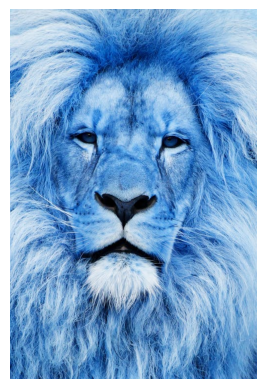

In [9]:
# input img
img = cv2.imread("animals/africa-african-animal-cat-41315.jpeg")
plt.imshow(img)
plt.axis('off')
plt.show()

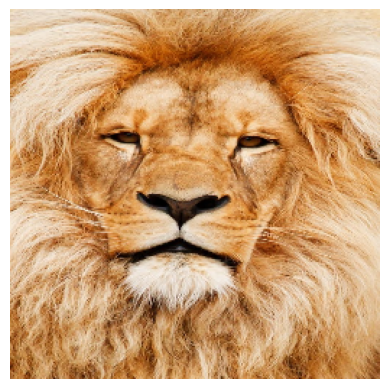

In [10]:
# format the input
SIZE=256 # image shape: (SIZE, SIZE, 3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change from BGR to RGB
img = cv2.resize(img, (SIZE, SIZE))
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
# append to the data set and scale it
img_data=[]
img_data.append(img_to_array(img))
img_arr = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_arr = img_arr.astype("float32")/ 255.


## Encoder Decoder Model

In [11]:
# clear session
clear_session()

In [12]:
# define model
model = Sequential(name="seq_model")
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu", use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, input_shape=(SIZE, SIZE, 3), name= "conv_layer_one"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', name="max_pool_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_two"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_two"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_three"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_three"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_four"))
model.add(UpSampling2D((2,2), interpolation='nearest', name="up_smaple_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_five"))
model.add(UpSampling2D((2,2), interpolation='nearest', name="up_smaple_layer_two"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_six"))
model.add(UpSampling2D((2,2), interpolation='nearest', name="up_smaple_layer_three"))
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_seven"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_one (Conv2D)              │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_one (MaxPooling2D)    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_two (Conv2D)              │ (None, 128, 128, 8)         │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_two (MaxPooling2D)    │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_three (Conv2D)            │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_three (MaxPooling2D)  │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_four (Conv2D)             │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_one (UpSampling2D)   │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_five (Conv2D)             │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_two (UpSampling2D)   │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_six (Conv2D)              │ (None, 128, 128, 32)        │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_three (UpSampling2D) │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_seven (Conv2D)            │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.get_config()

{'name': 'seq_model',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv_layer_one',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registe

In [14]:
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [20]:
# fit
model.fit(img_arr, img_arr, epochs=10, shuffle=True, verbose=0)

In [21]:
model.metrics_names

['loss', 'compile_metrics']

In [23]:
# predict
pred = model.predict(img_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


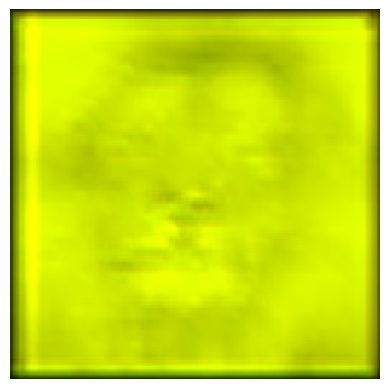

In [24]:
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(-0.5, 255.5, 255.5, -0.5)

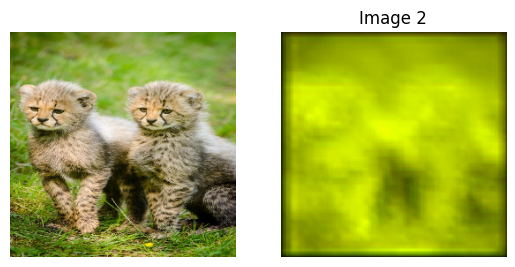

In [25]:
# test
img_test = cv2.imread("animals/cheetahs-cubs-two-together-162318.jpeg")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB) # change from BGR to RGB
img_test = cv2.resize(img_test, (SIZE, SIZE))
img_test = img_test.astype("float32")/ 255.
img_test = np.expand_dims(img_test, axis=0)

plt.subplot(1, 2, 1)
plt.imshow(img_test[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(model.predict(img_test)[0])
plt.title('Image 2')
plt.axis('off')

## Encoder Decoder Denoising

In [26]:
# load data
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# reshape inputs
SIZE = 28
x_train = x_train.astype("float32")/255.
x_train = np.reshape(x_train, (len(x_train), SIZE, SIZE, 1))
x_test = x_test.astype("float32")/255.
x_test = np.reshape(x_test, (len(x_test), SIZE, SIZE, 1))

In [28]:
# add noise
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

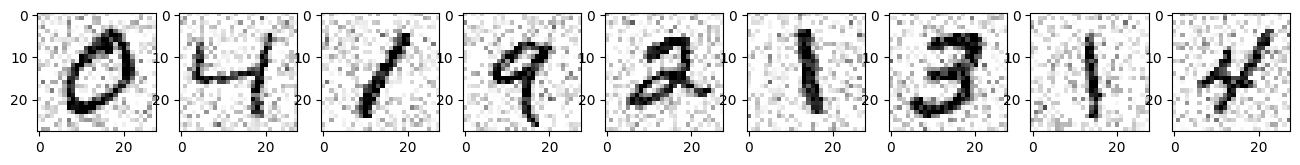

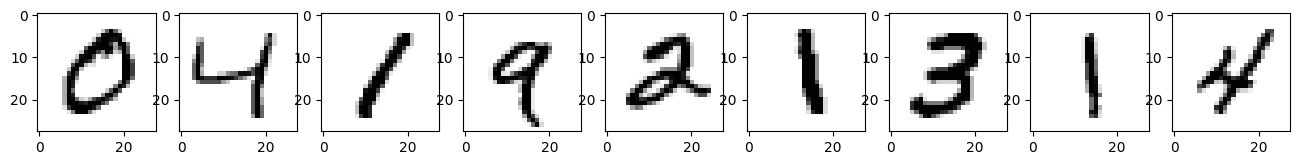

In [29]:
plt.figure(figsize=(18,2))
for i in range(1,10):
  ax = plt.subplot(1, 10, i)
  plt.imshow(x_train_noisy[i].reshape(SIZE,SIZE), cmap="binary")
plt.figure(figsize=(18,2))
for i in range(1,10):
  ax = plt.subplot(1, 10, i)
  plt.imshow(x_train[i].reshape(SIZE,SIZE), cmap="binary")
plt.show()

In [30]:
# clear session
clear_session()

In [31]:
# define model
model = Sequential(name="seq_model")
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", input_shape=(SIZE, SIZE, 1), name= "conv_layer_one"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', name="max_pool_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_two"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_two"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_three"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_three"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_four"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_five"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_two"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation="relu", name= "conv_layer_six"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_three"))
model.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_seven"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
# fit
model.fit(x_train_noisy, x_train, epochs=10, shuffle=True, verbose=0,
          batch_size=256, validation_data=(x_test_noisy, x_test))
# eval
eval = model.evaluate(x_test_noisy, x_test)

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_one (Conv2D)              │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_one (MaxPooling2D)    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_two (Conv2D)              │ (None, 14, 14, 8)           │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_two (MaxPooling2D)    │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_three (Conv2D)            │ (None, 7, 7, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_three (MaxPooling2D)  │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_four (Conv2D)             │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_one (UpSampling2D)   │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_five (Conv2D)             │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_two (UpSampling2D)   │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_six (Conv2D)              │ (None, 14, 14, 32)          │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_three (UpSampling2D) │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_seven (Conv2D)            │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,009 (27.38 KB)

 Trainable params: 7,009 (27.38 KB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8173 - loss: 0.0161


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


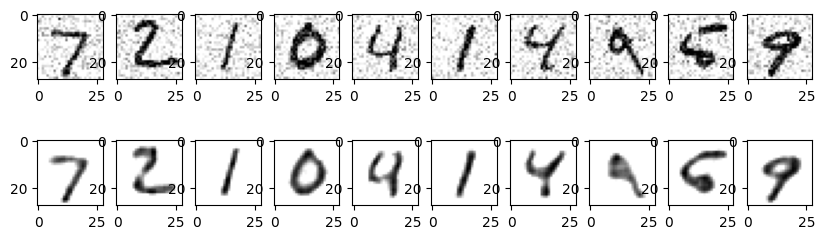

In [32]:
# predict
pred = model.predict(x_test_noisy)
plt.figure(figsize=(10,3))
for i in range(10):
  ax = plt.subplot(2, 10, i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28), cmap="binary")
  ax = plt.subplot(2, 10, 10+i+1)
  plt.imshow(pred[i].reshape(28,28), cmap="binary")

## Encoder Decoder Domain Adaption Using OpenCV

In [33]:
def rotate_image(image, angle):
    # Get the image center
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

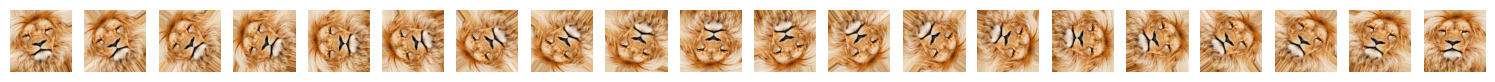

In [34]:
# input img
SIZE = 256 # image shape: (SIZE, SIZE, 3)
num_rotations = 20 # number of rotations
img_data = [] # data set
img = cv2.imread("animals/africa-african-animal-cat-41315.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change from BGR to RGB
img = cv2.resize(img, (SIZE, SIZE))
for i in range(num_rotations): # Rotate the image n times and save them in the list
    angle = (i + 1) * 360 / num_rotations
    img_rotated = rotate_image(img, angle)
    img_data.append(img_to_array(img_rotated)) # append
img_arr = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_arr = img_arr.astype("float32")/ 255. # scale

plt.figure(figsize=(num_rotations, 1)) # Display the original and rotated images
for i, img in enumerate(img_arr):
    plt.subplot(1, num_rotations + 1, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

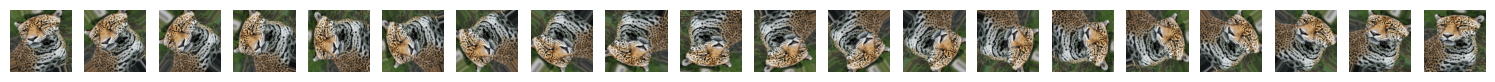

In [35]:
# output image
img_decode = [] # data set of images in new domain
img = cv2.imread("animals/photo-1528238344097-a8994f7c74e4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change from BGR to RGB
img = cv2.resize(img, (SIZE, SIZE))
for i in range(num_rotations): # Rotate the image n times and save them in the list
    angle = (i + 1) * 360 / num_rotations
    img_rotated = rotate_image(img, angle)
    img_decode.append(img_to_array(img_rotated)) # append
img_arr_new_domain = np.reshape(img_decode, (len(img_decode), SIZE, SIZE, 3))
img_arr_new_domain = img_arr_new_domain.astype("float32")/ 255. # scale

plt.figure(figsize=(num_rotations, 1)) # Display the original and rotated images
for i, img in enumerate(img_arr_new_domain):
    plt.subplot(1, num_rotations + 1, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_one (Conv2D)              │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_one (MaxPooling2D)    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_two (Conv2D)              │ (None, 128, 128, 8)         │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_two (MaxPooling2D)    │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_three (Conv2D)            │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_three (MaxPooling2D)  │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_four (Conv2D)             │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_one (UpSampling2D)   │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_five (Conv2D)             │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_two (UpSampling2D)   │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_six (Conv2D)              │ (None, 128, 128, 32)        │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_three (UpSampling2D) │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_seven (Conv2D)            │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


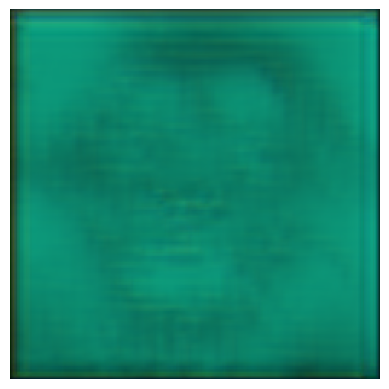

In [36]:
# define model
clear_session() # clear session
model = Sequential(name="seq_model")
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", input_shape=(SIZE, SIZE, 3), name= "conv_layer_one"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', name="max_pool_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_two"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_two"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_three"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_three"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_four"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_five"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_two"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_six"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_three"))
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_seven"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
# fit
model.fit(img_arr, img_arr_new_domain, epochs=10, shuffle=True, verbose=0)
# predict
pred = model.predict(img_arr)
# plot
plt.imshow(pred[-1].reshape(SIZE, SIZE, 3))
plt.axis('off')
plt.show()

## Encoder Decoder Domain Adaption Using ImageDataGenerator

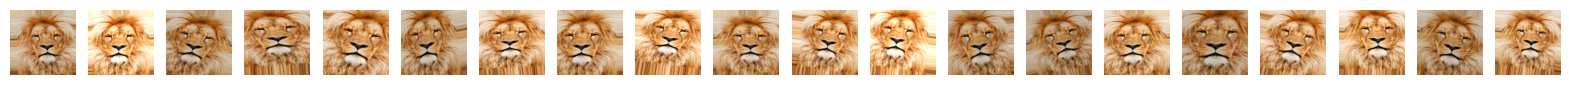

In [21]:
# input imgs
SIZE = 256
num_aug = 20 # number of aug imgs
img_data = [] # data set
image_path = "animals/africa-african-animal-cat-41315.jpeg"
image = load_img(image_path)
_image_arr = img_to_array(image)
image_arr = resize(_image_arr, (SIZE, SIZE))
image_arr = np.expand_dims(image_arr, axis=0)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')
seeds = np.random.randint(low=num_aug*10, size=num_aug)
for _ in range(num_aug): # generate images using the ImageDataGenerator
    augmented_image = next(datagen.flow(image_arr, seed=seeds[_]))[0]
    img_data.append(augmented_image.astype("float32")/255.)
input_images = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))

plt.figure(figsize=(num_aug, 1)) # Display images
for i, img in enumerate(input_images):
    plt.subplot(1, num_aug, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

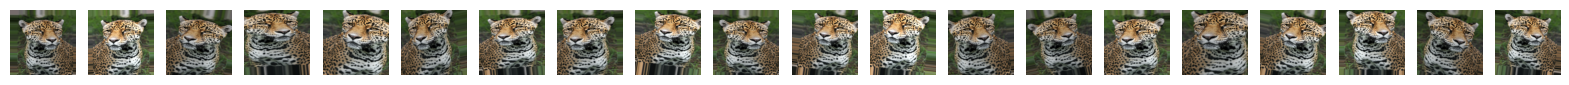

In [22]:
# output imgs
img_data = [] # data set
image_path = "animals/photo-1528238344097-a8994f7c74e4.jpg"
image = load_img(image_path)
_image_arr = img_to_array(image)
image_arr = resize(_image_arr, (SIZE, SIZE))
image_arr = np.expand_dims(image_arr, axis=0)
for _ in range(num_aug):
    augmented_image = next(datagen.flow(image_arr, seed=seeds[_]))[0]
    img_data.append(augmented_image.astype("float32")/255.)
output_images = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))

plt.figure(figsize=(num_aug, 1))
for i, img in enumerate(output_images):
    plt.subplot(1, num_aug, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_one (Conv2D)              │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_one (MaxPooling2D)    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_two (Conv2D)              │ (None, 128, 128, 8)         │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_two (MaxPooling2D)    │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_three (Conv2D)            │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_three (MaxPooling2D)  │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_four (Conv2D)             │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_one (UpSampling2D)   │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_five (Conv2D)             │ (None, 64, 64, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_two (UpSampling2D)   │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_six (Conv2D)              │ (None, 128, 128, 32)        │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_smaple_layer_three (UpSampling2D) │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_seven (Conv2D)            │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


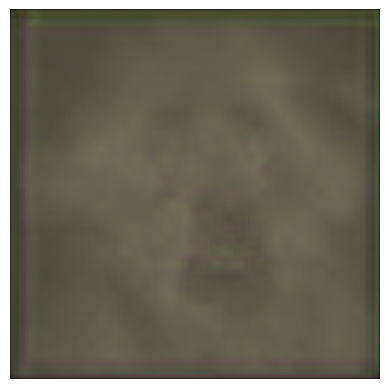

In [23]:
# define model
clear_session() # clear session
model = Sequential(name="seq_model")
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", input_shape=(SIZE, SIZE, 3), name= "conv_layer_one"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', name="max_pool_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_two"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_two"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_three"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name="max_pool_layer_three"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_four"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_one"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_five"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_two"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_six"))
model.add(UpSampling2D((2,2), name="up_smaple_layer_three"))
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_seven"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
# fit
model.fit(input_images, output_images, epochs=50, shuffle=True, verbose=0)
# predict
pred = model.predict(input_images)
# plot
plt.imshow(pred[0].reshape(SIZE, SIZE, 3))
plt.axis('off')
plt.show()

## Encoder Decoder Image Colorization

In [24]:
# read images
img_path = "animals/"
SIZE = 256
batch_size = 5
file_list = os.listdir(img_path)
img_data = [] # data set
output_data = []
for filename in file_list:
  if filename.endswith(('.png', '.jpg', '.jpeg')):
    image_path = os.path.join(img_path, filename)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype("float32")/255.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab) # change from BGR to LAB
    L, A, B = cv2.split(img)
    _AB = np.array([A, B])
    AB = np.einsum('kij->ijk', _AB)
    img_data.append(np.array(L))
    output_data.append(AB)
input = np.reshape(img_data, (len(img_data), SIZE, SIZE, 1)) / 100.
output = np.reshape(output_data, (len(output_data), SIZE, SIZE, 2)) / 128.

In [25]:
# define model
clear_session() # clear session
model = Sequential(name="seq_model")
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation="relu",
                 input_shape=(SIZE, SIZE, 1), name= "conv_layer_one"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_two"))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', activation="relu", name= "conv_layer_three"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_four"))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=2, padding='same', activation="relu", name= "conv_layer_five"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_six"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_seven"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_eight"))
model.add(UpSampling2D(size=(2, 2), name="up_sample_layer_one"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_nine"))
model.add(UpSampling2D(size=(2, 2), name="up_sample_layer_two"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_ten"))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_eleven"))
model.add(Conv2D(filters=2, kernel_size=(3,3), padding='same', activation="relu", name= "conv_layer_twelve"))
model.add(UpSampling2D(size=(2, 2), name="up_sample_layer_three"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
# fit
model.fit(input, output, validation_split=0.2, batch_size=16, epochs=2, shuffle=True, verbose=2)

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_one (Conv2D)              │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_two (Conv2D)              │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_three (Conv2D)            │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_four (Conv2D)             │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_five (Conv2D)             │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_six (Conv2D)              │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_seven (Conv2D)            │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_eight (Conv2D)            │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sample_layer_one (UpSampling2D)   │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_nine (Conv2D)             │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sample_layer_two (UpSampling2D)   │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_ten (Conv2D)              │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_eleven (Conv2D)           │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_twelve (Conv2D)           │ (None, 128, 128, 2)         │             290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sample_layer_three (UpSampling2D) │ (None, 256, 256, 2)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,859,602 (14.72 MB)

 Trainable params: 3,859,602 (14.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
5/5 - 69s - 14s/step - accuracy: 0.6903 - loss: 0.0340 - val_accuracy: 0.7489 - val_loss: 0.0138
Epoch 2/2
5/5 - 17s - 3s/step - accuracy: 0.8140 - loss: 0.0175 - val_accuracy: 0.7489 - val_loss: 0.0384


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<ipython-input-26-5a0e447bebf5>:7: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img = (color.lab2rgb(res) * 255).astype(np.uint8)


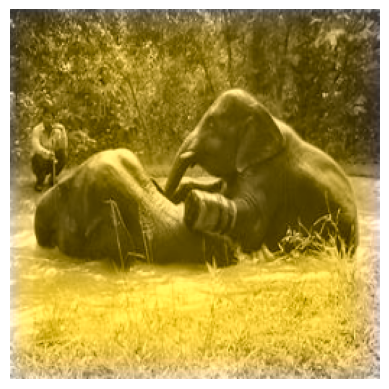

In [26]:
# predict
test_img = np.expand_dims(input[0], axis=0)
pred = model.predict(test_img)
res = np.zeros((SIZE, SIZE, 3))
res[:,:,0] = test_img[0][:,:,0] * 100.
res[:,:,1:] = pred[0] * 128.
img = (color.lab2rgb(res) * 255).astype(np.uint8)
# plot
plt.imshow(img)
plt.axis('off')
plt.show()

## Encoder Decoder Anomaly Detection

### Data Engineering

In [30]:
df = pd.read_csv("anomaly.csv")
df.head()

,Date,Power,Detector,Quality
0,1-Jan-16,96,8,Good
1,2-Jan-16,96,10,Good
2,3-Jan-16,91,8,Good
3,4-Jan-16,97,9,Good
4,5-Jan-16,91,11,Good


In [31]:
df.groupby("Quality")["Quality"].count()

,Quality
Quality,
Bad,407
Good,1054


In [32]:
df.drop(["Date"], axis=1, inplace=True)
df.dropna(inplace=True, axis=1)
df.Quality[df.Quality=="Good"] = 1
df.Quality[df.Quality=="Bad"] = 2

<ipython-input-32-36fc7c3f0594>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Quality[df.Quality=="Good"] = 1
<ipython-input-32-36fc7c3f0594>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [33]:
mask_normal = (df["Quality"]==1)
mask_anormal = (df["Quality"]==2)

In [34]:
type(mask_anormal)

pandas.core.series.Series

In [35]:
df.drop("Quality", axis=1, inplace=True)

In [36]:
df_normal = df[mask_normal]
df_anormal = df[mask_anormal]

In [37]:
X_normal = df_normal.values
X_anormal = df_anormal.values

In [38]:
X_normal.shape

(1054, 2)

### Network Architecture

In [39]:
X_train, X_test = train_test_split(X_normal, test_size=.25, random_state=42)

In [54]:
# define model
clear_session() # clear session
model = Sequential(name="seq_model")
model.add(Dense(10, input_dim=X_train.shape[1], activation="relu", name="dense_layer_one"))
model.add(Dense(5, activation="relu", name="dense_layer_two"))
model.add(Dense(10, activation="relu", name="dense_layer_three"))
model.add(Dense(X_train.shape[1], name="dense_layer_four"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
# fit
model.fit(X_train, X_train, epochs=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_layer_one (Dense)              │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_two (Dense)              │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_three (Dense)            │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_four (Dense)             │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

25/25 - 2s - 89ms/step - accuracy: 0.0000e+00 - loss: 4353.0576


In [67]:
# pred
mse = tf.keras.metrics.MeanSquaredError()
_scores = []
mse.update_state(model.predict(X_test), X_test)
_scores.append(np.sqrt(mse.result().numpy()))
mse.update_state(model.predict(X_normal), X_normal)
_scores.append(np.sqrt(mse.result().numpy()))
mse.update_state(model.predict(X_anormal), X_anormal)
_scores.append(np.sqrt(mse.result().numpy()))
scores = pd.DataFrame([_scores], columns=["X_test", "X_normal", "X_anormal"])
scores

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,X_test,X_normal,X_anormal
0,63.899632,63.835331,64.509338


## Encoder Decoder LSTM Anomaly Detection

### Data Engineering

In [50]:
dataframe = pd.read_csv("GE.csv")
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-17,79.919998,80.660004,79.760002,80.489998,80.247856,8492200
1,2023-01-18,80.940002,81.180000,79.139999,79.269997,79.031525,7834300
2,2023-01-19,77.940002,78.750000,76.669998,76.860001,76.628777,10411700
3,2023-01-20,77.589996,77.750000,75.669998,77.680000,77.446312,8261300
4,2023-01-23,77.610001,80.019997,77.540001,79.769997,79.530022,10957500


In [51]:
df = dataframe[["Date", "Close"]]
df.Date = pd.to_datetime(df.Date)
df.head()

<ipython-input-51-142d5051e2a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Date = pd.to_datetime(df.Date)


,Date,Close
0,2023-01-17,80.489998
1,2023-01-18,79.269997
2,2023-01-19,76.860001
3,2023-01-20,77.680000
4,2023-01-23,79.769997


In [52]:
df["Date"].dtype

dtype('<M8[ns]')

In [53]:
len(df)

250

In [54]:
print("Start data is:", df["Date"].min())
print("End data is:", df["Date"].max())

Start data is: 2023-01-17 00:00:00
End data is: 2024-01-12 00:00:00


<Axes: xlabel='Date', ylabel='Close'>

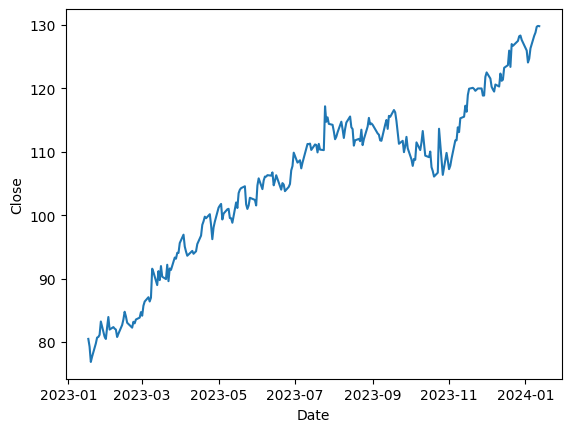

In [55]:
sns.lineplot(x=df["Date"], y=df["Close"])


### Network Architecture

In [56]:
X_train, X_test = df.loc[df["Date"] <= "2023-09-17"], df.loc[df["Date"] > "2023-09-17"]

In [57]:
scaler = StandardScaler().fit(X_train[["Close"]])
X_train["Close"] = scaler.transform(X_train[["Close"]])
X_test["Close"] = scaler.transform(X_test[["Close"]])

<ipython-input-57-02b2fe57e065>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Close"] = scaler.transform(X_train[["Close"]])
<ipython-input-57-02b2fe57e065>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Close"] = scaler.transform(X_test[["Close"]])


In [58]:
seq_size = 15
def to_seq(x, y, seq_size=1):
  xval, yval = [], []
  for i in range(len(x)-seq_size):
    xval.append(x.iloc[i:(i+seq_size)].values)
    yval.append(y.iloc[i+seq_size].values)
  return np.array(xval), np.array(yval)

Xtrain, Ytrain = to_seq(X_train[["Close"]], X_train[["Close"]], seq_size)
Xtest, Ytest = to_seq(X_test[["Close"]], X_test[["Close"]], seq_size)

In [59]:
print(Xtrain.shape, Ytrain.shape)

(153, 15, 1) (153, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_layer_one (LSTM)                │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_out_layer_one (Dropout)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vec_layer_one (RepeatVector)  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_two (LSTM)                │ (None, 15, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_out_layer_two (Dropout)         │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distrib_layer_one               │ (None, 15, 1)               │             129 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7/7 - 6s - 839ms/step - loss: 0.4602 - val_loss: 0.5303
Epoch 2/20
7/7 - 0s - 13ms/step - loss: 0.2605 - val_loss: 0.3213
Epoch 3/20
7/7 - 0s - 21ms/step - loss: 0.2157 - val_loss: 0.1997
Epoch 4/20
7/7 - 0s - 17ms/step - loss: 0.1808 - val_loss: 0.2329
Epoch 5/20
7/7 - 0s - 12ms/step - loss: 0.1773 - val_loss: 0.1633
Epoch 6/20
7/7 - 0s - 12ms/step - loss: 0.1596 - val_loss: 0.1911
Epoch 7/20
7/7 - 0s - 21ms/step - loss: 0.1570 - val_loss: 0.1508
Epoch 8/20
7/7 - 0s - 14ms/step - loss: 0.1510 - val_loss: 0.1445
Epoch 9/20
7/7 - 0s - 19ms/step - loss: 0.1535 - val_loss: 0.1418
Epoch 10/20
7/7 - 0s - 12ms/step - loss: 0.1471 - val_loss: 0.1676
Epoch 11/20
7/7 - 0s - 12ms/step - loss: 0.1457 - val_loss: 0.1336
Epoch 12/20
7/7 - 0s - 20ms/step - loss: 0.1507 - val_loss: 0.1459
Epoch 13/20
7/7 - 0s - 15ms/step - loss: 0.1441 - val_loss: 0.1589
Epoch 14/20
7/7 - 0s - 17ms/step - loss: 0.1455 - val_loss: 0.1397
Epoch 15/20
7/7 - 0s - 12ms/step - loss: 0.1446 - val_loss: 0.1307
Epo

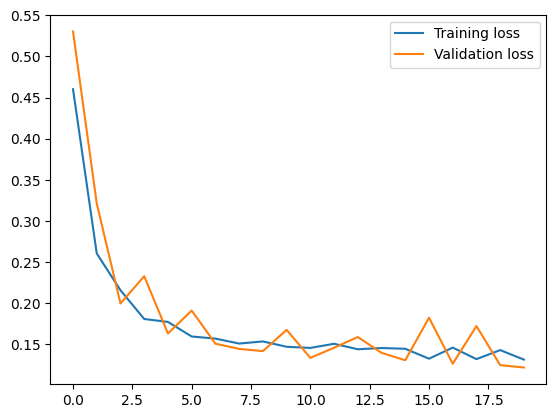

In [60]:
# define model
clear_session() # clear session
model = Sequential(name="seq_model")
model.add(LSTM(128, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), name="lstm_layer_one"))
model.add(Dropout(rate=0.2, name="drop_out_layer_one"))
model.add(RepeatVector(Xtrain.shape[1], name="repeat_vec_layer_one"))
model.add(LSTM(128, return_sequences=True, name="lstm_layer_two"))
model.add(Dropout(rate=0.2, name="drop_out_layer_two"))
model.add(TimeDistributed(Dense(Xtrain.shape[2]), name="time_distrib_layer_one"))
model.summary()
# compile
model.compile(optimizer="adam", loss="mean_absolute_error")
# fit
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=20,
                    validation_split=0.1, verbose=2)
# plot
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(array([1., 1., 2., 3., 5., 3., 2., 6., 2., 5., 4., 1., 4., 2., 3., 2., 4.,
        1., 2., 2., 2., 2., 0., 1., 1., 0., 1., 2., 1., 2.]),
 array([0.08690049, 0.09539709, 0.10389369, 0.1123903 , 0.1208869 ,
        0.1293835 , 0.1378801 , 0.1463767 , 0.1548733 , 0.16336991,
        0.17186651, 0.18036311, 0.18885971, 0.19735631, 0.20585291,
        0.21434952, 0.22284612, 0.23134272, 0.23983932, 0.24833592,
        0.25683252, 0.26532913, 0.27382573, 0.28232233, 0.29081893,
        0.29931553, 0.30781213, 0.31630874, 0.32480534, 0.33330194,
        0.34179854]),
 <BarContainer object of 30 artists>)

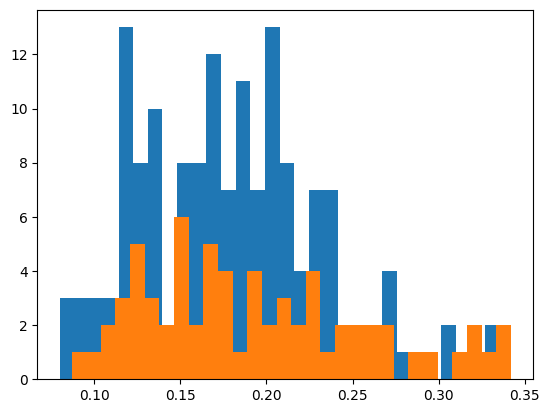

In [61]:
# pred
pred_train = model.predict(Xtrain)
Xtrain_mae = np.mean(np.abs(pred_train-Xtrain), axis=1)
plt.hist(Xtrain_mae, bins=30)
threshold = 0.3
pred_test = model.predict(Xtest)
Xtest_mae = np.mean(np.abs(pred_test-Xtest), axis=1)
plt.hist(Xtest_mae, bins=30)

In [62]:
anomaly_df = pd.DataFrame(X_test[seq_size:])
anomaly_df["testMAE"] = Xtest_mae
anomaly_df["max_trainMAE"] = threshold
anomaly_df["anomaly"] = anomaly_df["testMAE"] > anomaly_df["max_trainMAE"]
anomaly_df["Close"] = X_test[seq_size:]["Close"]

<Axes: xlabel='Date', ylabel='testMAE'>

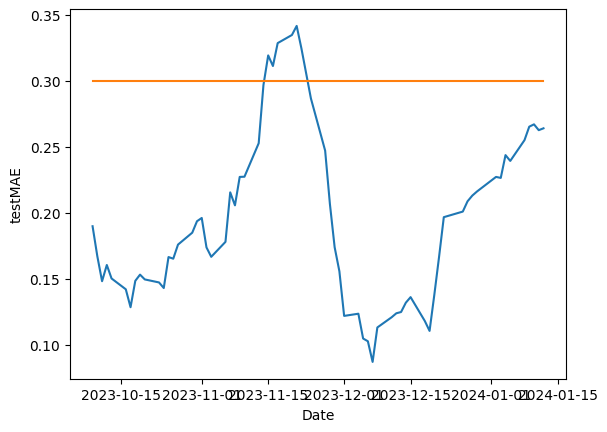

In [63]:
sns.lineplot(x=anomaly_df["Date"], y=anomaly_df["testMAE"])
sns.lineplot(x=anomaly_df["Date"], y=anomaly_df["max_trainMAE"])

In [64]:
scaler.inverse_transform([anomaly_df["Close"]])

array([[110.260002, 111.480003, 113.260002, 111.330002, 109.379997,
        109.139999, 110.019997, 107.57    , 106.949997, 106.080002,
        106.690002, 113.620003, 111.199997, 108.800003, 106.349998,
        109.809998, 108.629997, 107.25    , 107.779999, 108.919998,
        111.779999, 111.800003, 113.849998, 113.089996, 115.269997,
        115.519997, 117.25    , 116.300003, 118.940002, 119.93    ,
        120.07    , 119.889999, 119.599998, 119.970001, 119.970001,
        118.849998, 118.860001, 121.800003, 122.5     , 121.529999,
        120.230003, 119.809998, 119.480003, 120.589996, 120.279999,
        122.32    , 121.18    , 121.349998, 123.230003, 123.639999,
        125.940002, 123.370003, 126.970001, 126.690002, 127.470001,
        128.199997, 128.320007, 127.629997, 125.949997, 124.059998,
        124.660004, 126.290001, 128.279999, 128.779999, 129.699997,
        129.830002, 129.789993]])

<Axes: xlabel='Date'>

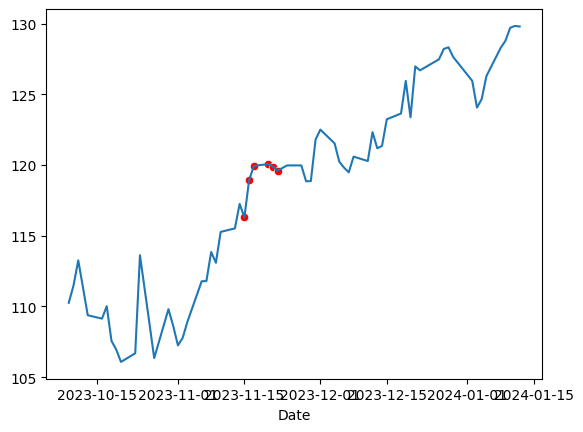

In [65]:
anomalies = anomaly_df.loc[anomaly_df["anomaly"] == True]
sns.lineplot(x=anomaly_df["Date"], y=scaler.inverse_transform([anomaly_df["Close"]])[0])
sns.scatterplot(x=anomalies["Date"], y=scaler.inverse_transform([anomalies["Close"]])[0], color="red")

## Variational Auto Encoder

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
rand_ind = np.random.choice(len(x_train), 2000, replace=False)
x_train, y_train = x_train[rand_ind], y_train[rand_ind]
rand_ind = np.random.choice(len(x_test), 200, replace=False)
x_test, y_test = x_test[rand_ind], y_test[rand_ind]

In [14]:
x_train = x_train.astype("float32")/ 255.
x_test = x_test.astype("float32")/ 255.

In [15]:
img_width, img_height = x_train.shape[1], x_train.shape[2]
num_channels = 1
input_shape = (img_width, img_height, num_channels)

In [16]:
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, num_channels)

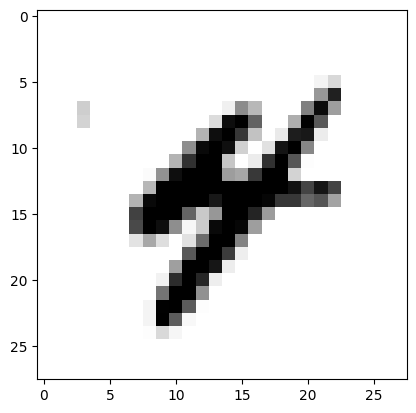

In [17]:
plt.figure(1)
plt.subplot(111)
plt.imshow(x_train[32][:,:,0], cmap="gray_r")

In [19]:
clear_session()
# disable_eager_execution()
latent_dim = 2
input_img = Input(shape=input_shape, name="encoder_input")
x = Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = Conv2D(64, 3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
conv_shape = backend.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
z_mu = Dense(latent_dim, name="latent_mu")(x)
z_sigma = Dense(latent_dim, name="latent_sigma")(x)
def sample_z(args):
  z_mu, z_sigma = args
  eps = backend.random_normal(shape=(backend.shape(z_mu)[0],
                                     backend.int_shape(z_mu)[1]))
  return z_mu + backend.exp(z_sigma/2.) * eps
z = Lambda(sample_z, output_shape=(latent_dim, ), name="z")([z_mu, z_sigma])
encoder = Model(input_img, [z_mu, z_sigma, z], name="encoder")
print(encoder.summary())
decoder_input = Input(shape=(latent_dim, ), name="decoder_input")
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3],
          activation="relu")(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2DTranspose(num_channels, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(decoder_input, x, name="decoder")
decoder.summary()
z_decoded = decoder(z)
class CustumLayer(Layer):
  def vae_loss(self, x, z_decoded):
    x = backend.flatten(x)
    z_decoded = backend.flatten(z_decoded)
    recon_loss = metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-1 * backend.mean(1 + z_sigma - backend.square(z_mu) - backend.exp(z_sigma), axis=-1)
    return backend.mean(recon_loss + 1e-3*kl_loss)
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x
y = CustumLayer()([input_img, z_decoded, z_mu, z_sigma])
vae = Model(input_img, y, name="vae")
vae.compile(optimizer="adam", loss=None)
vae.summary()
vae.fit(x_train, None, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 1)      │         56,385 │ z[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custum_layer              │ (None, 28, 28, 1)      │              0 │ encoder_input[0][0],   │
│ (CustumLayer)             │                        │                │ decoder[0][0],         │
│                           │                        │                │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 550,629 (2.10 MB)

 Trainable params: 550,629 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


TypeError: Exception encountered when calling CustumLayer.call().

[1mLayer.add_loss() got an unexpected keyword argument 'inputs'[0m

Arguments received by CustumLayer.call():
  • inputs=['tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)', 'tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)', 'tf.Tensor(shape=(32, 2), dtype=float32)', 'tf.Tensor(shape=(32, 2), dtype=float32)']

In [ ]:
print("Encoder:", encoder.output_shape, "\nDecoder:", decoder.output_shape, "\nVAE:", vae.output_shape)

In [ ]:
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize=(6,4))
plt.scatter(mu[:,0], mu[:,1], c=y_test, cmap="brg")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.colorbar()
plt.show()

In [ ]:
sample_vec = np.array([[1,3]])
_decoded_example = decoder.predict(sample_vec)
decoded_example = _decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example)

In [ ]:
n = 20
figure = np.zeros((img_width * n, img_height * n, num_channels))
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit
plt.figure(figsize=(10, 10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.show()

## Conditional Variational Auto Encoder

In [73]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [74]:
rand_ind = np.random.choice(len(x_train), 2000, replace=False)
x_train, y_train = x_train[rand_ind], y_train[rand_ind]
rand_ind = np.random.choice(len(x_test), 200, replace=False)
x_test, y_test = x_test[rand_ind], y_test[rand_ind]

In [75]:
x_train = x_train.astype("float32")/ 255.
x_test = x_test.astype("float32")/ 255.

In [76]:
img_width, img_height = x_train.shape[1], x_train.shape[2]
num_channels = 1
input_shape = (img_width, img_height, num_channels)

In [77]:
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, num_channels)

In [78]:
num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

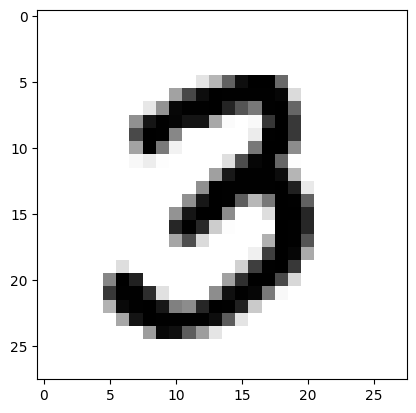

In [79]:
plt.figure(1)
plt.subplot(111)
plt.imshow(x_train[32][:,:,0], cmap="gray_r")

In [80]:
clear_session()
disable_eager_execution()
latent_dim = 2
input_img = Input(shape=input_shape, name="encoder_input")
img_label = Input(shape=(num_classes,), name="conditional_info")
x = Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = Conv2D(64, 3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
conv_shape = backend.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
x = Concatenate()([x, img_label])
z_mu = Dense(latent_dim, name="latent_mu")(x)
z_sigma = Dense(latent_dim, name="latent_sigma")(x)
def sample_z(args):
  z_mu, z_sigma = args
  eps = backend.random_normal(shape=(backend.shape(z_mu)[0],
                                     backend.int_shape(z_mu)[1]))
  return z_mu + backend.exp(z_sigma/2.) * eps
z = Lambda(sample_z, output_shape=(latent_dim, ), name="z")([z_mu, z_sigma])
encoder = Model([input_img, img_label], [z_mu, z_sigma, z], name="encoder")
print(encoder.summary())
decoder_input = Input(shape=(latent_dim, ), name="decoder_input")
x = Concatenate()([decoder_input, img_label])
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3],
          activation="relu")(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2DTranspose(num_channels, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model([decoder_input, img_label], x, name="decoder")
decoder.summary()
z_decoded = decoder([z, img_label])
class CustumLayer(Layer):
  def vae_loss(self, x, z_decoded):
    x = backend.flatten(x)
    z_decoded = backend.flatten(z_decoded)
    recon_loss = metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-1 * backend.mean(1 + z_sigma - backend.square(z_mu) - backend.exp(z_sigma), axis=-1)
    return backend.mean(recon_loss + 1e-3*kl_loss)
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x
y = CustumLayer()([input_img, z_decoded, img_label])
cvae = Model([input_img, img_label], y, name="cvae")
cvae.compile(optimizer="adam", loss=None)
cvae.summary()
cvae.fit([x_train, y_train], None, epochs=2, batch_size=32, validation_split=0.2, verbose=2)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conditional_info          │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 42)             │              0 │ dense[0][0],           │
│                           │                        │                │ conditional_info[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             86 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             86 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 494,284 (1.89 MB)

 Trainable params: 494,284 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conditional_info          │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 12)             │              0 │ decoder_input[0][0],   │
│ (Concatenate)             │                        │                │ conditional_info[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 12544)          │        163,072 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 14, 14, 64)     │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 28, 28, 32)     │         18,464 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_output            │ (None, 28, 28, 1)      │            289 │ conv2d_transpose[0][0] │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 181,825 (710.25 KB)

 Trainable params: 181,825 (710.25 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Exception encountered when calling CustumLayer.call().

[1mCould not automatically infer the output shape / dtype of 'custum_layer' (of type CustumLayer). Either the `CustumLayer.call()` method is incorrect, or you need to implement the `CustumLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Tried to convert 'x' to a tensor and failed. Error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
[0m

Arguments received by CustumLayer.call():
  • args=(['<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=None, name=encoder_input>', '<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_15>', '<KerasTensor shape=(None, 10), dtype=float32, sparse=None, name=conditional_info>'],)
  • kwargs=<class 'inspect._empty'>

In [ ]:
print("Encoder:", encoder.output_shape, "\nDecoder:", decoder.output_shape, "\nCanditional VAE:", cvae.output_shape)

In [ ]:
mu, _, _ = encoder.predict([x_test, y_test])
plt.figure(figsize=(6,4))
plt.scatter(mu[:,0], mu[:,1], c=np.argmax(y_test, axis=1), cmap="brg")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.colorbar()
plt.show()